# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=60,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_16-36-41/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4745 | MulticlassF1Score=0.1138
Batch-30 : CrossEntropyLoss=2.4682 | MulticlassF1Score=0.1874
Batch-45 : CrossEntropyLoss=2.4826 | MulticlassF1Score=0.2086
Batch-60 : CrossEntropyLoss=2.4586 | MulticlassF1Score=0.2262
Batch-75 : CrossEntropyLoss=2.4200 | MulticlassF1Score=0.2532
Batch-90 : CrossEntropyLoss=2.4145 | MulticlassF1Score=0.2846
Batch-105: CrossEntropyLoss=2.4162 | MulticlassF1Score=0.3135
Batch-120: CrossEntropyLoss=2.3941 | MulticlassF1Score=0.3378
Batch-135: CrossEntropyLoss=2.3778 | MulticlassF1Score=0.3621
Batch-150: CrossEntropyLoss=2.3747 | MulticlassF1Score=0.3849
Batch-165: CrossEntropyLoss=2.3667 | MulticlassF1Score=0.4041
Batch-180: CrossEntropyLoss=2.3798 | MulticlassF1Score=0.4196
Batch-195: CrossEntropyLoss=2.3896 | MulticlassF1Score=0.4331
Batch-210: CrossEntropyLoss=2.3743 | MulticlassF1Score=0.4447
Batch-225: CrossEntropyLoss=2.3761 | MulticlassF1Score=0.4549
Batch-226: CrossEntropyLoss=2.3827 | MulticlassF1Score=0.4552

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3695 | MulticlassF1Score=0.5906
Batch-30 : CrossEntropyLoss=2.3577 | MulticlassF1Score=0.5875
Batch-45 : CrossEntropyLoss=2.3528 | MulticlassF1Score=0.5903
Batch-60 : CrossEntropyLoss=2.3858 | MulticlassF1Score=0.5915
Batch-63 : CrossEntropyLoss=2.3808 | MulticlassF1Score=0.5908

Training   : Mean CrossEntropyLoss = 2.4261 | Mean MulticlassF1Score = 0.3087
Validation : Mean CrossEntropyLoss = 2.3741 | Mean MulticlassF1Score = 0.5879

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3814 | MulticlassF1Score=0.5950
Batch-30 : CrossEntropyLoss=2.3554 | MulticlassF1Score=0.6186
Batch-45 : CrossEntropyLoss=2.3585 | MulticlassF1Score=0.6378
Batch-60 : CrossEntropyLoss=2.3493 | MulticlassF1Score=0.6463
Batch-75 : CrossEntropyLoss=2.3523 | MulticlassF1Score=0.6521
Batch-90 : CrossEntropyLoss=2.3425 | MulticlassF1Score=0.6569
Batch-105: CrossEntropyLoss=2.3551 | MulticlassF1Score=0.6600
Batch-120: CrossEntropyLoss=2.3587 | MulticlassF1Score=0.6621
Batch-135: CrossEntropyLoss=2.3520 | MulticlassF1Score=0.6633
Batch-150: CrossEntropyLoss=2.3348 | MulticlassF1Score=0.6664
Batch-165: CrossEntropyLoss=2.3386 | MulticlassF1Score=0.6712
Batch-180: CrossEntropyLoss=2.3250 | MulticlassF1Score=0.6753
Batch-195: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.6800
Batch-210: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.6834
Batch-225: CrossEntropyLoss=2.3341 | MulticlassF1Score=0.6859
Batch-226: CrossEntropyLoss=2.3472 | MulticlassF1Score=0.6859

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3210 | MulticlassF1Score=0.7183
Batch-30 : CrossEntropyLoss=2.3473 | MulticlassF1Score=0.7151
Batch-45 : CrossEntropyLoss=2.3327 | MulticlassF1Score=0.7177
Batch-60 : CrossEntropyLoss=2.3479 | MulticlassF1Score=0.7174
Batch-63 : CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7185

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3461 | Mean MulticlassF1Score = 0.6541
Validation : Mean CrossEntropyLoss = 2.3353 | Mean MulticlassF1Score = 0.7169

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3245 | MulticlassF1Score=0.7247
Batch-30 : CrossEntropyLoss=2.3462 | MulticlassF1Score=0.7247
Batch-45 : CrossEntropyLoss=2.3291 | MulticlassF1Score=0.7255
Batch-60 : CrossEntropyLoss=2.3156 | MulticlassF1Score=0.7367
Batch-75 : CrossEntropyLoss=2.3140 | MulticlassF1Score=0.7459
Batch-90 : CrossEntropyLoss=2.3174 | MulticlassF1Score=0.7531
Batch-105: CrossEntropyLoss=2.3124 | MulticlassF1Score=0.7590
Batch-120: CrossEntropyLoss=2.3354 | MulticlassF1Score=0.7629
Batch-135: CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7660
Batch-150: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7690
Batch-165: CrossEntropyLoss=2.3168 | MulticlassF1Score=0.7712
Batch-180: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7733
Batch-195: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7749
Batch-210: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.7766
Batch-225: CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7778
Batch-226: CrossEntropyLoss=2.3132 | MulticlassF1Score=0.7778

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2982 | MulticlassF1Score=0.7969
Batch-30 : CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7946
Batch-45 : CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7929
Batch-60 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7911
Batch-63 : CrossEntropyLoss=2.3060 | MulticlassF1Score=0.7908

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3173 | Mean MulticlassF1Score = 0.7546
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7936

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7931
Batch-30 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.7961
Batch-45 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.7980
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.7963
Batch-75 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.7970
Batch-90 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.7963
Batch-105: CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7976
Batch-120: CrossEntropyLoss=2.3016 | MulticlassF1Score=0.7982
Batch-135: CrossEntropyLoss=2.3096 | MulticlassF1Score=0.7985
Batch-150: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7993
Batch-165: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.8004
Batch-180: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8011
Batch-195: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8019
Batch-210: CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8025
Batch-225: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8028
Batch-226: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.8028

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8086
Batch-30 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8056
Batch-45 : CrossEntropyLoss=2.3145 | MulticlassF1Score=0.8041
Batch-60 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8029
Batch-63 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8032

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3091 | Mean MulticlassF1Score = 0.7979
Validation : Mean CrossEntropyLoss = 2.3085 | Mean MulticlassF1Score = 0.8047

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8108
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8095
Batch-45 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8103
Batch-60 : CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8123
Batch-75 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8117
Batch-90 : CrossEntropyLoss=2.3163 | MulticlassF1Score=0.8115
Batch-105: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.8109
Batch-120: CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8102
Batch-135: CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8112
Batch-150: CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8131
Batch-165: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8147
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8158
Batch-195: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8170
Batch-210: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8181
Batch-225: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8189
Batch-226: CrossEntropyLoss=2.3040 | MulticlassF1Score=0.8189

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8225
Batch-30 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8251
Batch-45 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8249
Batch-60 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8248
Batch-63 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8243

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8126
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8251

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8305
Batch-30 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8308
Batch-45 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8326
Batch-60 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8340
Batch-75 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8336
Batch-90 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8323
Batch-105: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8323
Batch-120: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8319
Batch-135: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8317
Batch-150: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8312
Batch-165: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8315
Batch-180: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8320
Batch-195: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8321
Batch-210: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8321
Batch-225: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8320
Batch-226: CrossEntropyLoss=2.3032 | MulticlassF1Score=0.8320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8270
Batch-30 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8249
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8252
Batch-60 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8252
Batch-63 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8248

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8321
Validation : Mean CrossEntropyLoss = 2.3016 | Mean MulticlassF1Score = 0.8251

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8283
Batch-30 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8315
Batch-45 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8336
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8309
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8312
Batch-90 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8321
Batch-105: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8330
Batch-135: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8329
Batch-150: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8333
Batch-165: CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8331
Batch-180: CrossEntropyLoss=2.3065 | MulticlassF1Score=0.8333
Batch-195: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8337
Batch-210: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8337
Batch-225: CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8334
Batch-226: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8334

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8276
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8237
Batch-45 : CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8258
Batch-60 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8258
Batch-63 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2992 | Mean MulticlassF1Score = 0.8321
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8250

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8398
Batch-30 : CrossEntropyLoss=2.3047 | MulticlassF1Score=0.8375
Batch-45 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8367
Batch-60 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8348
Batch-75 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8361
Batch-90 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8355
Batch-105: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8363
Batch-120: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8350
Batch-135: CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8352
Batch-150: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8356
Batch-165: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8353
Batch-180: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8351
Batch-195: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8348
Batch-210: CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8348
Batch-225: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8347
Batch-226: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8347

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8266
Batch-30 : CrossEntropyLoss=2.2980 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8267
Batch-60 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8272
Batch-63 : CrossEntropyLoss=2.3125 | MulticlassF1Score=0.8262

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2988 | Mean MulticlassF1Score = 0.8360
Validation : Mean CrossEntropyLoss = 2.3012 | Mean MulticlassF1Score = 0.8264

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8333
Batch-30 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8356
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8359
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8351
Batch-75 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8347
Batch-90 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8356
Batch-105: CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8359
Batch-120: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8357
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8363
Batch-150: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8361
Batch-165: CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8363
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8368
Batch-195: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8379
Batch-210: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8390
Batch-225: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8396
Batch-226: CrossEntropyLoss=2.3073 | MulticlassF1Score=0.8396

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8387
Batch-30 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8409
Batch-45 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8404
Batch-60 : CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8418
Batch-63 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8423

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2973 | Mean MulticlassF1Score = 0.8358
Validation : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8387

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8522
Batch-30 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8517
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8542
Batch-60 : CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8533
Batch-75 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8532
Batch-90 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8526
Batch-105: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8525
Batch-120: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8525
Batch-135: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8526
Batch-150: CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8523
Batch-165: CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8526
Batch-180: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8522
Batch-195: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8521
Batch-210: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8522
Batch-225: CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8524
Batch-226: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8523

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8457
Batch-30 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8437
Batch-45 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8423
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8428
Batch-63 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8427

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8525
Validation : Mean CrossEntropyLoss = 2.2963 | Mean MulticlassF1Score = 0.8448

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8524
Batch-30 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8532
Batch-45 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8531
Batch-60 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8538
Batch-75 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8545
Batch-90 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8548
Batch-105: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8547
Batch-120: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8570
Batch-135: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8590
Batch-150: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8613
Batch-165: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8630
Batch-180: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8643
Batch-195: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8655
Batch-210: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8664
Batch-225: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8676
Batch-226: CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8724
Batch-30 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8731
Batch-45 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8728
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8717
Batch-63 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8718

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2889 | Mean MulticlassF1Score = 0.8582
Validation : Mean CrossEntropyLoss = 2.2874 | Mean MulticlassF1Score = 0.8735

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8827
Batch-30 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8830
Batch-45 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8826
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8834
Batch-75 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8831
Batch-90 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8836
Batch-105: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8828
Batch-120: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8827
Batch-135: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8833
Batch-150: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8832
Batch-165: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8834
Batch-180: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8833
Batch-195: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8836
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8836
Batch-225: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8839
Batch-226: CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8838

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8749
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8736
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8732
Batch-60 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8725
Batch-63 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8730

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8832
Validation : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8742

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8853
Batch-45 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8865
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8867
Batch-75 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8865
Batch-90 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8866
Batch-105: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8865
Batch-120: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8864
Batch-135: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8854
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.8855
Batch-165: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8855
Batch-180: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8858
Batch-195: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8858
Batch-210: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8859
Batch-225: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8859
Batch-226: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8860

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8731
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8779
Batch-45 : CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8763
Batch-60 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8750
Batch-63 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8747

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2831 | Mean MulticlassF1Score = 0.8862
Validation : Mean CrossEntropyLoss = 2.2864 | Mean MulticlassF1Score = 0.8763

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8857
Batch-30 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8888
Batch-45 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8880
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8873
Batch-75 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8873
Batch-90 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8878
Batch-105: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8880
Batch-120: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8877
Batch-135: CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8877
Batch-150: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8882
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8878
Batch-180: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8882
Batch-195: CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8882
Batch-210: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8881
Batch-225: CrossEntropyLoss=2.2869 | MulticlassF1Score=0.8879
Batch-226: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8879

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8748
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8746
Batch-45 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8748
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8753
Batch-63 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8752

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2824 | Mean MulticlassF1Score = 0.8874
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8757

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8878
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8884
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8878
Batch-75 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8873
Batch-90 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8881
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.8882
Batch-120: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8889
Batch-135: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8890
Batch-150: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8892
Batch-165: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8890
Batch-180: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8891
Batch-195: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8892
Batch-210: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8891
Batch-225: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8892
Batch-226: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8892

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8725
Batch-30 : CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8743
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8737
Batch-60 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8759
Batch-63 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8755

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2819 | Mean MulticlassF1Score = 0.8881
Validation : Mean CrossEntropyLoss = 2.2860 | Mean MulticlassF1Score = 0.8744

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8911
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8898
Batch-45 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8899
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8896
Batch-75 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8903
Batch-90 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.8910
Batch-105: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8912
Batch-120: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8911
Batch-135: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8907
Batch-150: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8910
Batch-165: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8908
Batch-180: CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8906
Batch-195: CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8902
Batch-210: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8901
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.8901
Batch-226: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8901

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8755
Batch-30 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8756
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8773
Batch-60 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8759
Batch-63 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8765

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8906
Validation : Mean CrossEntropyLoss = 2.2857 | Mean MulticlassF1Score = 0.8752

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8876
Batch-30 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.8897
Batch-45 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8913
Batch-60 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8910
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8909
Batch-90 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8903
Batch-105: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8904
Batch-120: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8902
Batch-135: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8905
Batch-150: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8908
Batch-165: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8910
Batch-180: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8912
Batch-195: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8913
Batch-210: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8910
Batch-225: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8914
Batch-226: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8914

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8740
Batch-30 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8785
Batch-45 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8775
Batch-60 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8774
Batch-63 : CrossEntropyLoss=2.2993 | MulticlassF1Score=0.8769

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2811 | Mean MulticlassF1Score = 0.8901
Validation : Mean CrossEntropyLoss = 2.2856 | Mean MulticlassF1Score = 0.8762

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8916
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8912
Batch-45 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8926
Batch-75 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8927
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8931
Batch-105: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8932
Batch-120: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8929
Batch-135: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8930
Batch-150: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8926
Batch-165: CrossEntropyLoss=2.2769 | MulticlassF1Score=0.8926
Batch-180: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8922
Batch-195: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8924
Batch-210: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8927
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8930
Batch-226: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8930

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8763
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8806
Batch-45 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8807
Batch-60 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.8812
Batch-63 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8812

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2807 | Mean MulticlassF1Score = 0.8924
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8788

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8994
Batch-30 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8960
Batch-45 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8965
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8973
Batch-75 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8975
Batch-90 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8970
Batch-105: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8970
Batch-120: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8966
Batch-135: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8961
Batch-150: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8962
Batch-165: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8962
Batch-180: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8966
Batch-195: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8968
Batch-210: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8969
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.8967
Batch-226: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8967

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8783
Batch-30 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8811
Batch-45 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8812
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8815
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8816

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8970
Validation : Mean CrossEntropyLoss = 2.2839 | Mean MulticlassF1Score = 0.8802

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8977
Batch-30 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8989
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8993
Batch-60 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8990
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8995
Batch-90 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8987
Batch-105: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8982
Batch-120: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8987
Batch-135: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8986
Batch-150: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8983
Batch-165: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8980
Batch-180: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8980
Batch-195: CrossEntropyLoss=2.2779 | MulticlassF1Score=0.8979
Batch-210: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8981
Batch-225: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8979
Batch-226: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8978

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8793
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8812
Batch-45 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8821
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8839

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2792 | Mean MulticlassF1Score = 0.8984
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8832

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8964
Batch-30 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8986
Batch-45 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8976
Batch-60 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8988
Batch-75 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.8984
Batch-90 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.8983
Batch-105: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8990
Batch-120: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9011
Batch-135: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9040
Batch-150: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9053
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9069
Batch-180: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9082
Batch-195: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9092
Batch-210: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9100
Batch-225: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9105
Batch-226: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9105

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9050
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9053
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9048
Batch-60 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9052
Batch-63 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9056

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9026
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9048

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9189
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9221
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9229
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9243
Batch-75 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9239
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9239
Batch-105: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9244
Batch-120: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9247
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9248
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9247
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9248
Batch-180: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9253
Batch-195: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9252
Batch-210: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9256
Batch-225: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9254
Batch-226: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9254

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9103
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9113
Batch-45 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9099
Batch-60 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9108
Batch-63 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9111

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9238
Validation : Mean CrossEntropyLoss = 2.2751 | Mean MulticlassF1Score = 0.9100

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9274
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9285
Batch-90 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9287
Batch-105: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9289
Batch-120: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9297
Batch-135: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9302
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9308
Batch-165: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9315
Batch-195: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9319
Batch-210: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9322
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9324
Batch-226: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9324

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9162
Batch-30 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9147
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9187
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9200

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9299
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9163

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9401
Batch-30 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9379
Batch-75 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9379
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9381
Batch-120: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9384
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9383
Batch-165: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9382
Batch-180: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9381
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9379
Batch-210: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9376
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9376
Batch-226: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9376

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9220
Batch-30 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9192
Batch-63 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9197

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2669 | Mean MulticlassF1Score = 0.9383
Validation : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9211

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9378
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9391
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9385
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9372
Batch-75 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9379
Batch-105: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9385
Batch-120: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9386
Batch-150: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9387
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9386
Batch-180: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9384
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9388
Batch-210: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9385
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9385

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9212
Batch-30 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9205
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9201
Batch-60 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9205
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9204

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2665 | Mean MulticlassF1Score = 0.9384
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9202

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9384
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9393
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9379
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9376
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9384
Batch-105: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9391
Batch-120: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9392
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9397
Batch-150: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9397
Batch-165: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9393
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9394
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9393
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9391
Batch-225: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9391
Batch-226: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9391

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9194
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9192
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9191
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9206
Batch-63 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9205

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9389
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9186

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9400
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9407
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9405
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9408
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9406
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9399
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9402
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9404
Batch-135: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9402
Batch-150: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9398
Batch-165: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9398
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9397
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9397
Batch-210: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9397
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9395

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9191
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9204
Batch-45 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9210
Batch-63 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9207

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2662 | Mean MulticlassF1Score = 0.9401
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9196

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9421
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9423
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9423
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9419
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9422
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9415
Batch-165: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9413
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9408
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9404
Batch-226: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9403

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9199
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9210
Batch-60 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.9212
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9213

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2660 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9197

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9419
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9411
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9408
Batch-90 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9405
Batch-105: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9401
Batch-120: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9411
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9414
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9410
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9413
Batch-210: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9411
Batch-226: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9411

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9238
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9223
Batch-63 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9224

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9411
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9229

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9424
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9426
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9426
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9418
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9425
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9425
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9421
Batch-195: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9416
Batch-225: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9414
Batch-226: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9414

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9222
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9231
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9239
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9229

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9415
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9424
Batch-75 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9420
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9423
Batch-105: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9428
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9432
Batch-150: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9439
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9438
Batch-195: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9439
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9437
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9437

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9246
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9260
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9265
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9257
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9430
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9251

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9456
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9457
Batch-195: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9455
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9455

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9260
Batch-63 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9459
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9263

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9438
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9460
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9463
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9462
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9459
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9461
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9461
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9307
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9290
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9266
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9461
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9288

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9453
Batch-30 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9469
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9467
Batch-135: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9468
Batch-165: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9470
Batch-180: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9470
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9469
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9468
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9470
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9470

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9233
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9259
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9258
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9465
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9255

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9462
Batch-45 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9488
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9492
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9488
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9485
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9489
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9488
Batch-150: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9488
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9486
Batch-180: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9482
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9481
Batch-225: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9268
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9265

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9478
Validation : Mean CrossEntropyLoss = 2.2702 | Mean MulticlassF1Score = 0.9273

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9487
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9487
Batch-75 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9479
Batch-90 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9480
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9485
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9495
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9511
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9525
Batch-180: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9537
Batch-195: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9545
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9552
Batch-225: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9560
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9412
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9448
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9455
Batch-63 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9450

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2611 | Mean MulticlassF1Score = 0.9505
Validation : Mean CrossEntropyLoss = 2.2645 | Mean MulticlassF1Score = 0.9432

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9671
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9673
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9676
Batch-180: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9678
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9676
Batch-226: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9676

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9468
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9697
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9692
Batch-90 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9689
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9482
Batch-45 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9478

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9676
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9681
Batch-90 : CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9683
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9683
Batch-135: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9459

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9694
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9689
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9687
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9688
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9475

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9480
Patience = 1/50❗

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9741
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9718
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9711
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9469
Batch-30 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9701
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9483

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9716
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9712
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9699
Batch-135: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9695
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9476

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9687
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9687
Batch-226: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9687

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9509
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9507
Batch-45 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9470

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9501
Patience = 2/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9690
Batch-60 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9693
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9689
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9691
Batch-226: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9691

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9478

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9708
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9687
Batch-135: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9478

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9479
Patience = 3/50❗

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9699
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9693
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9690
Batch-150: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9691
Batch-195: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9485

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9712
Batch-30 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9725
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9717
Batch-60 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9716
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9704
Batch-120: CrossEntropyLoss=2.2516 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9700
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9700
Batch-210: CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9699
Batch-225: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9707
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9464

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9705
Batch-180: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9706
Batch-195: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9708
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9707
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9707
Batch-226: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9707

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2565 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9470

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9724
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9718
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9716
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9716
Batch-105: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9715
Batch-135: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9714
Batch-150: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9712
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9710
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9712
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9711
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9711
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9711

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9494
Batch-45 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2563 | Mean MulticlassF1Score = 0.9715
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9485

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9718
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9711
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9711
Batch-90 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9711
Batch-135: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9711
Batch-150: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9712
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9715
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9715
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9716
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9716

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9539
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9532
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9532
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9531
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9528

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2561 | Mean MulticlassF1Score = 0.9714
Validation : Mean CrossEntropyLoss = 2.2623 | Mean MulticlassF1Score = 0.9537

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2561
Best CrossEntropyLoss training    : 2.2623
Best MulticlassF1Score validation : 0.9714
Best MulticlassF1Score validation : 0.9537
Training duration                 : 2.4854 minutes.
Training date                     : 2022-10-19 11:31:24.496845+08:00


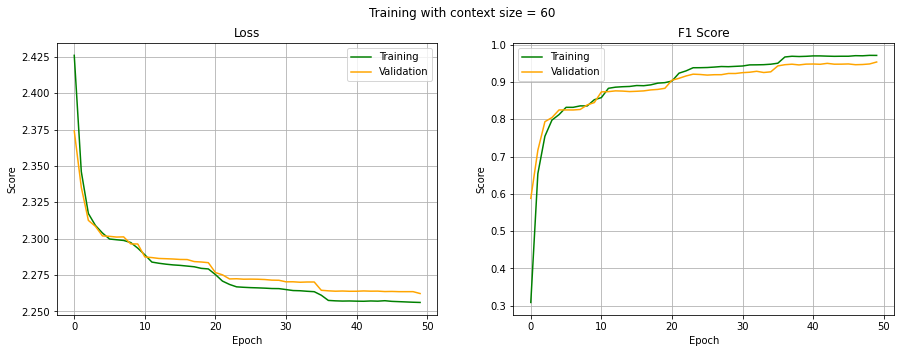

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9767, device='cuda:0'),
 tensor(0.9528, device='cuda:0'),
 tensor(0.9530, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9767, device='cuda:0'),
 tensor(0.9528, device='cuda:0'),
 tensor(0.9530, device='cuda:0'))

## Heatmap

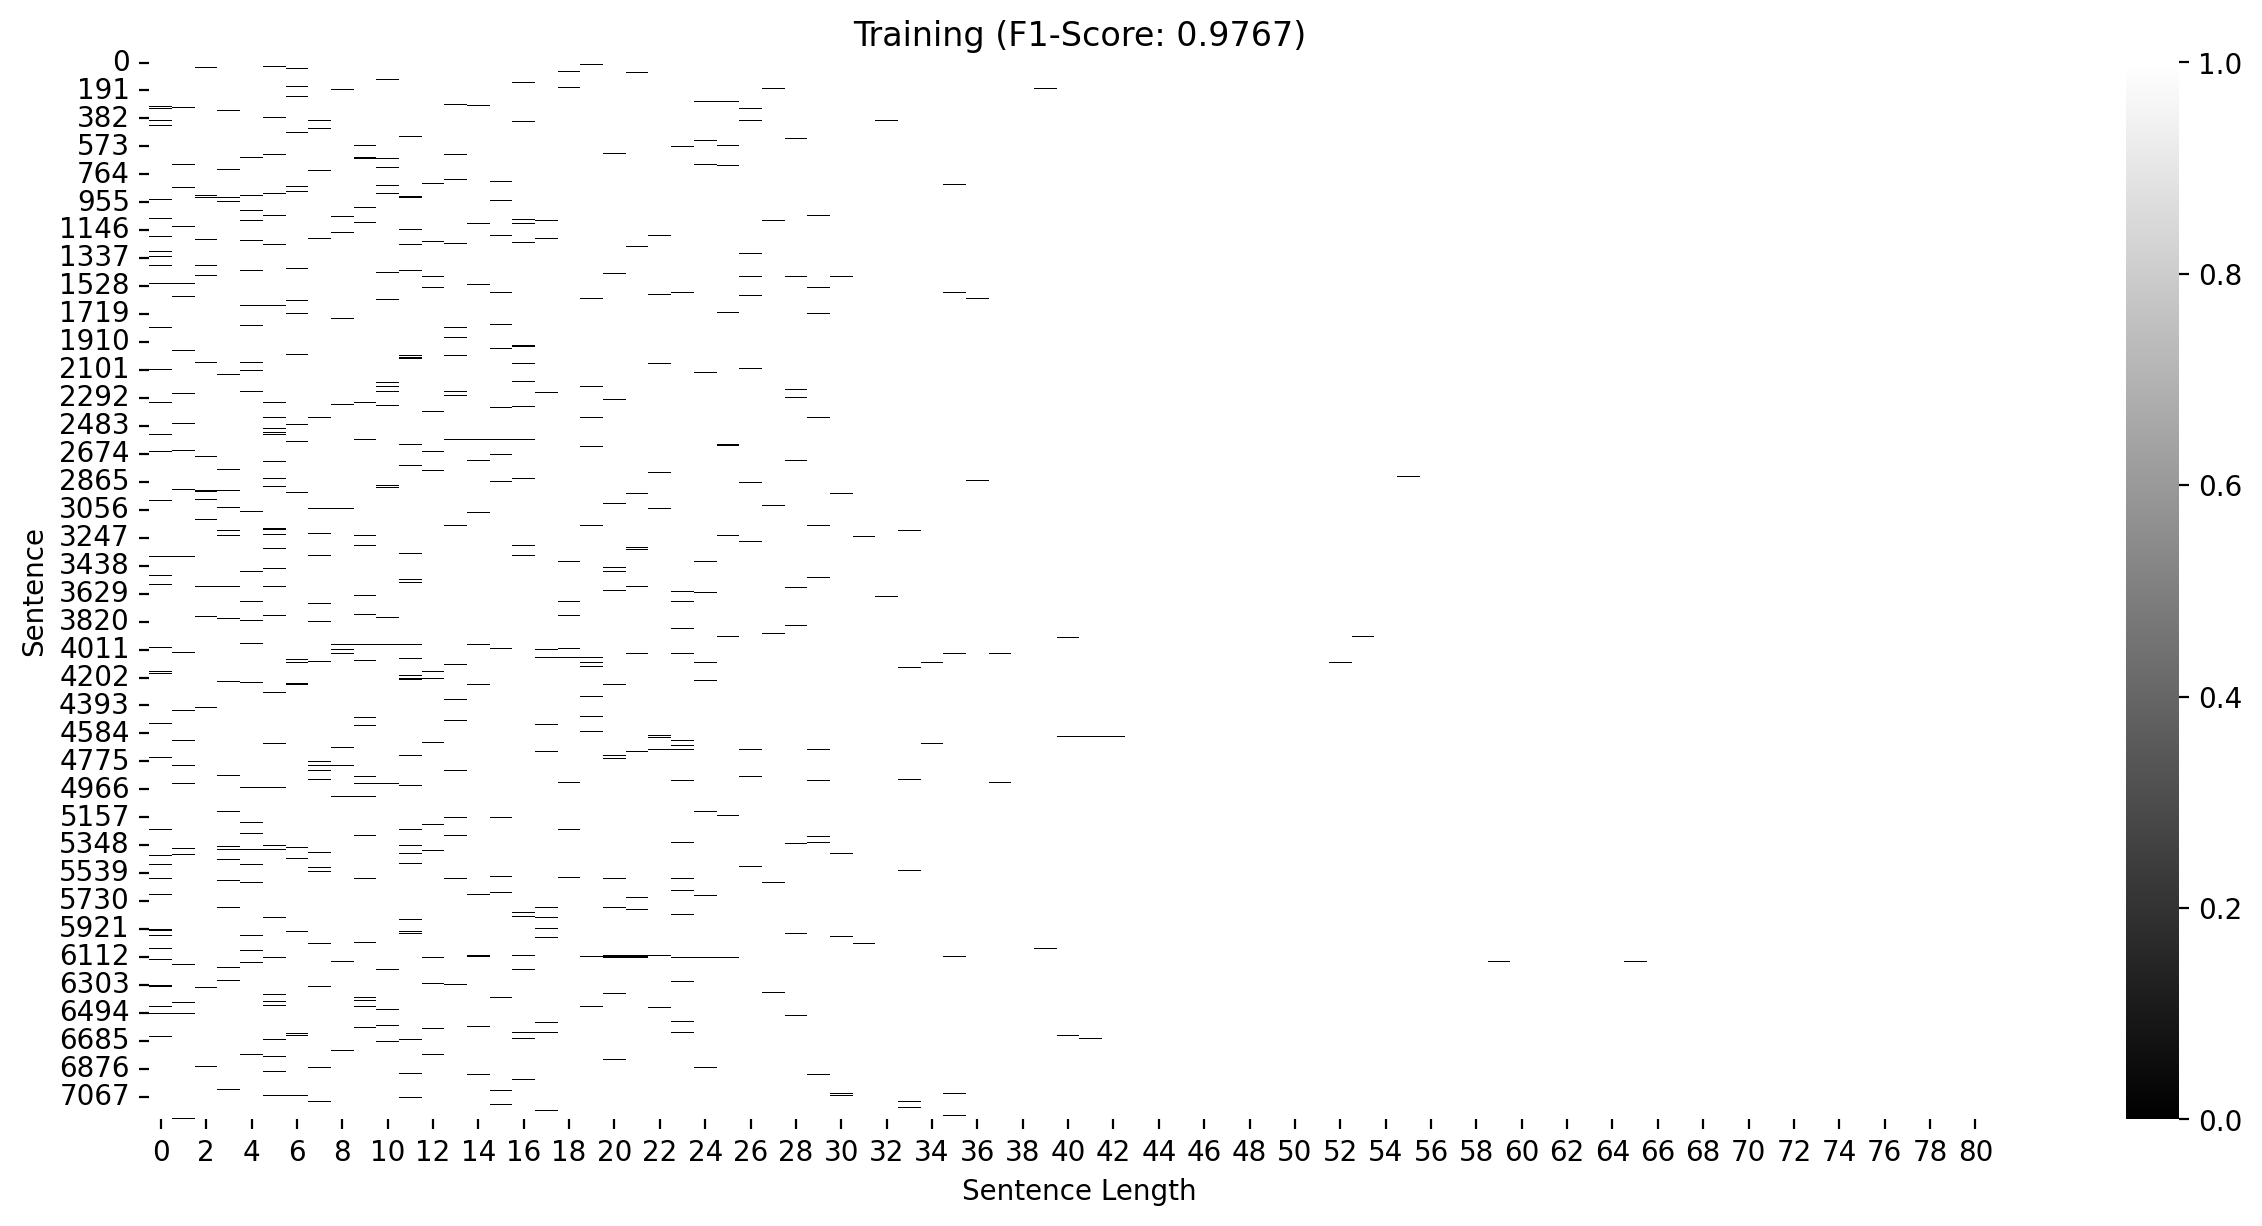

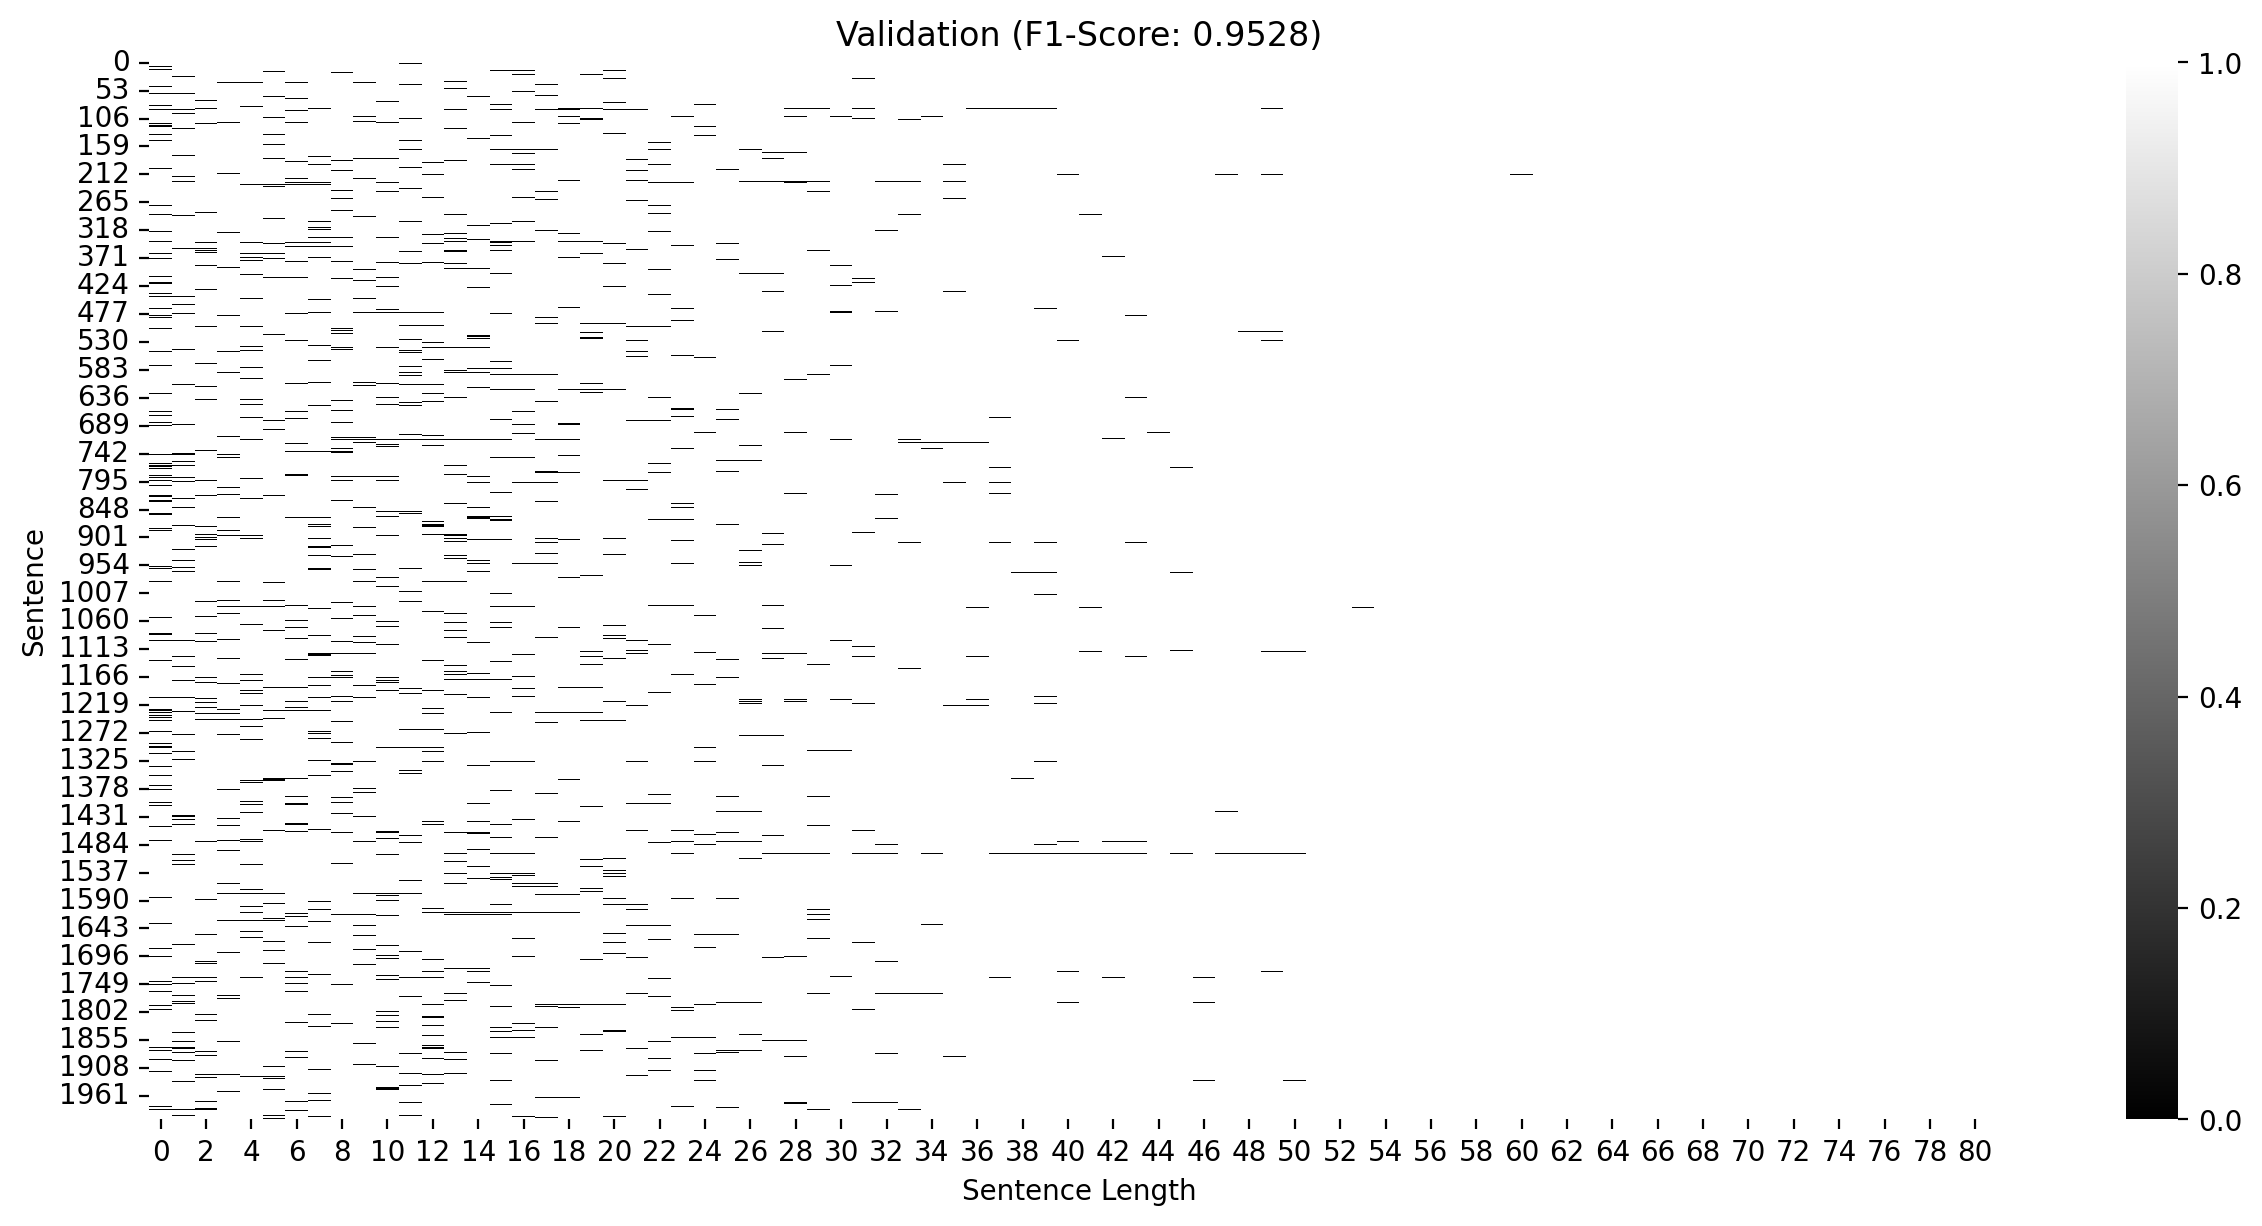

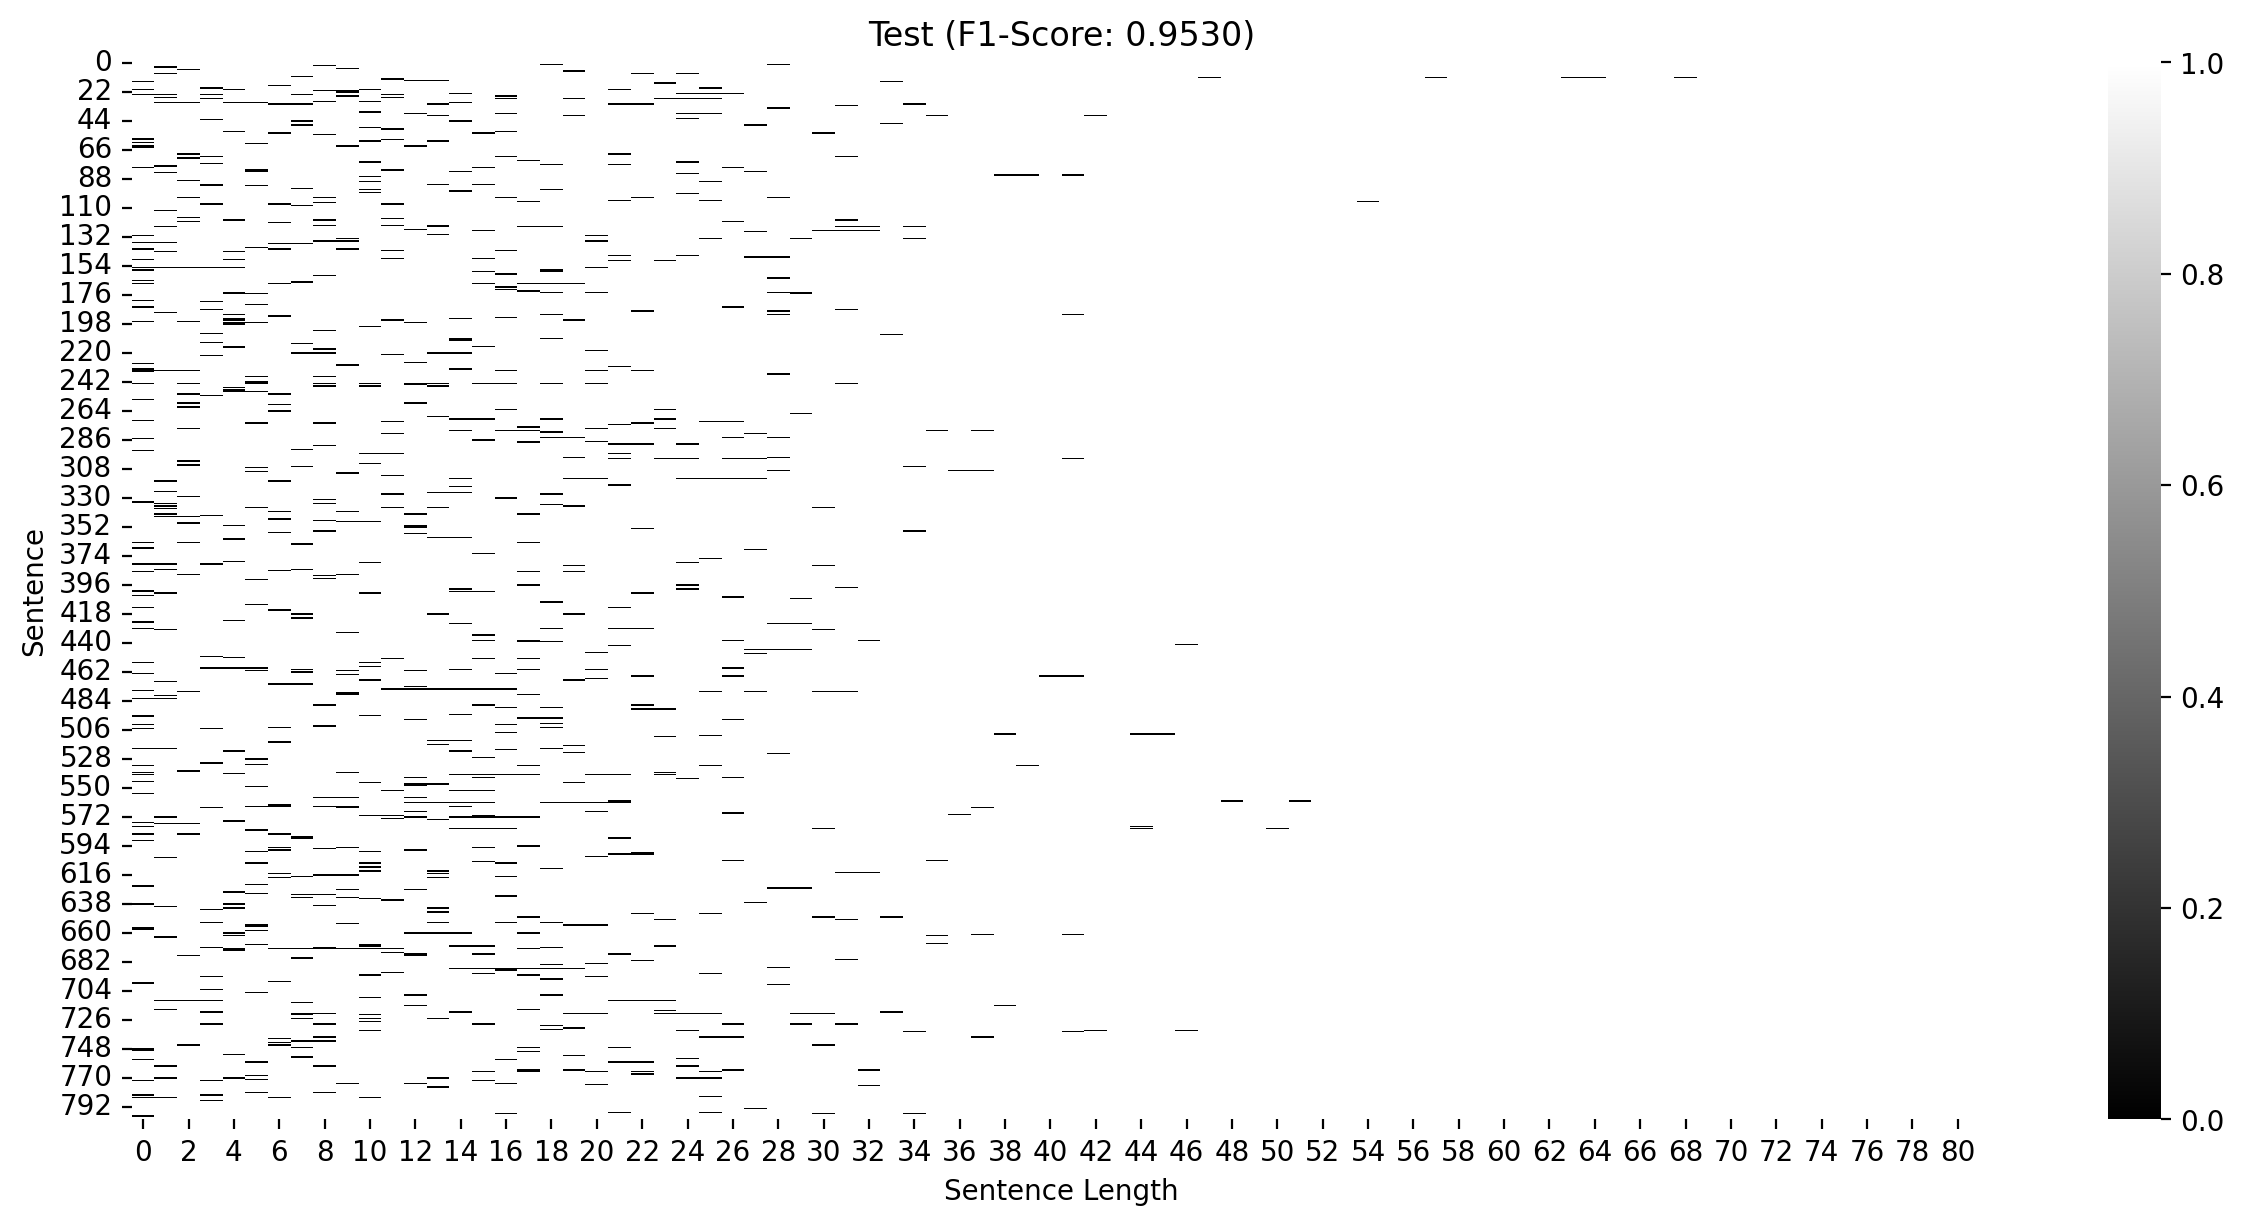

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 72 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


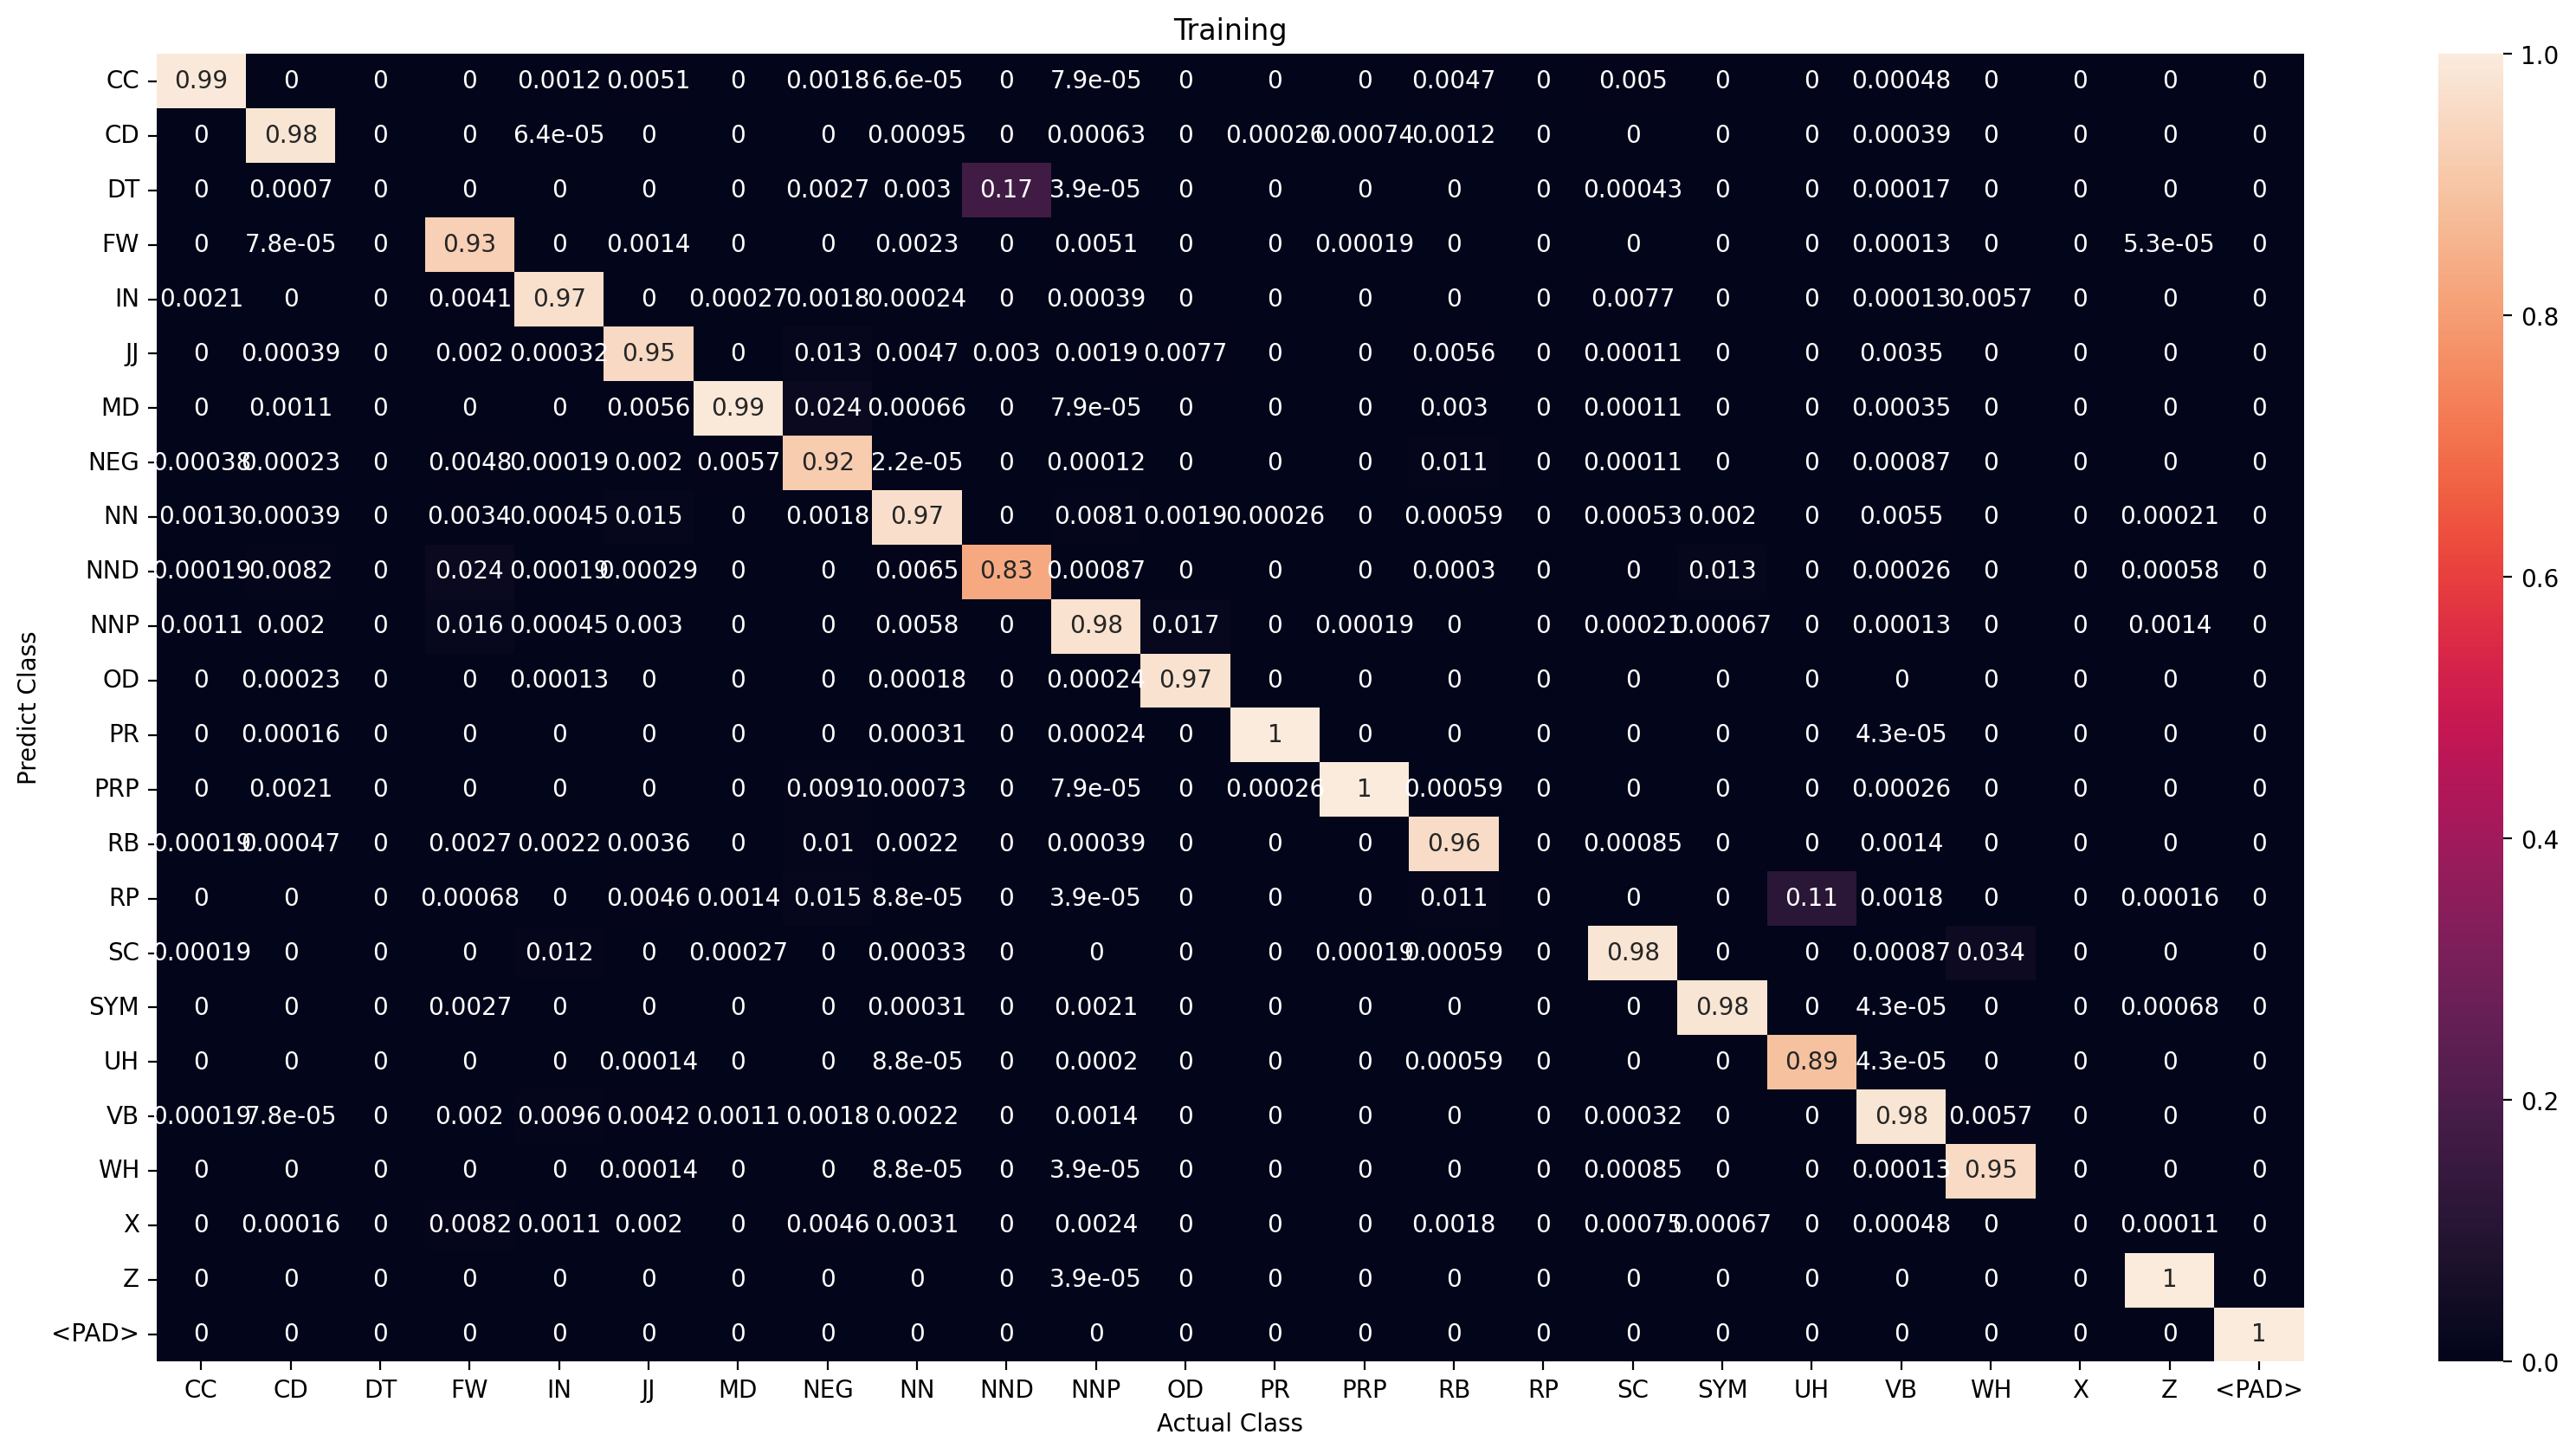

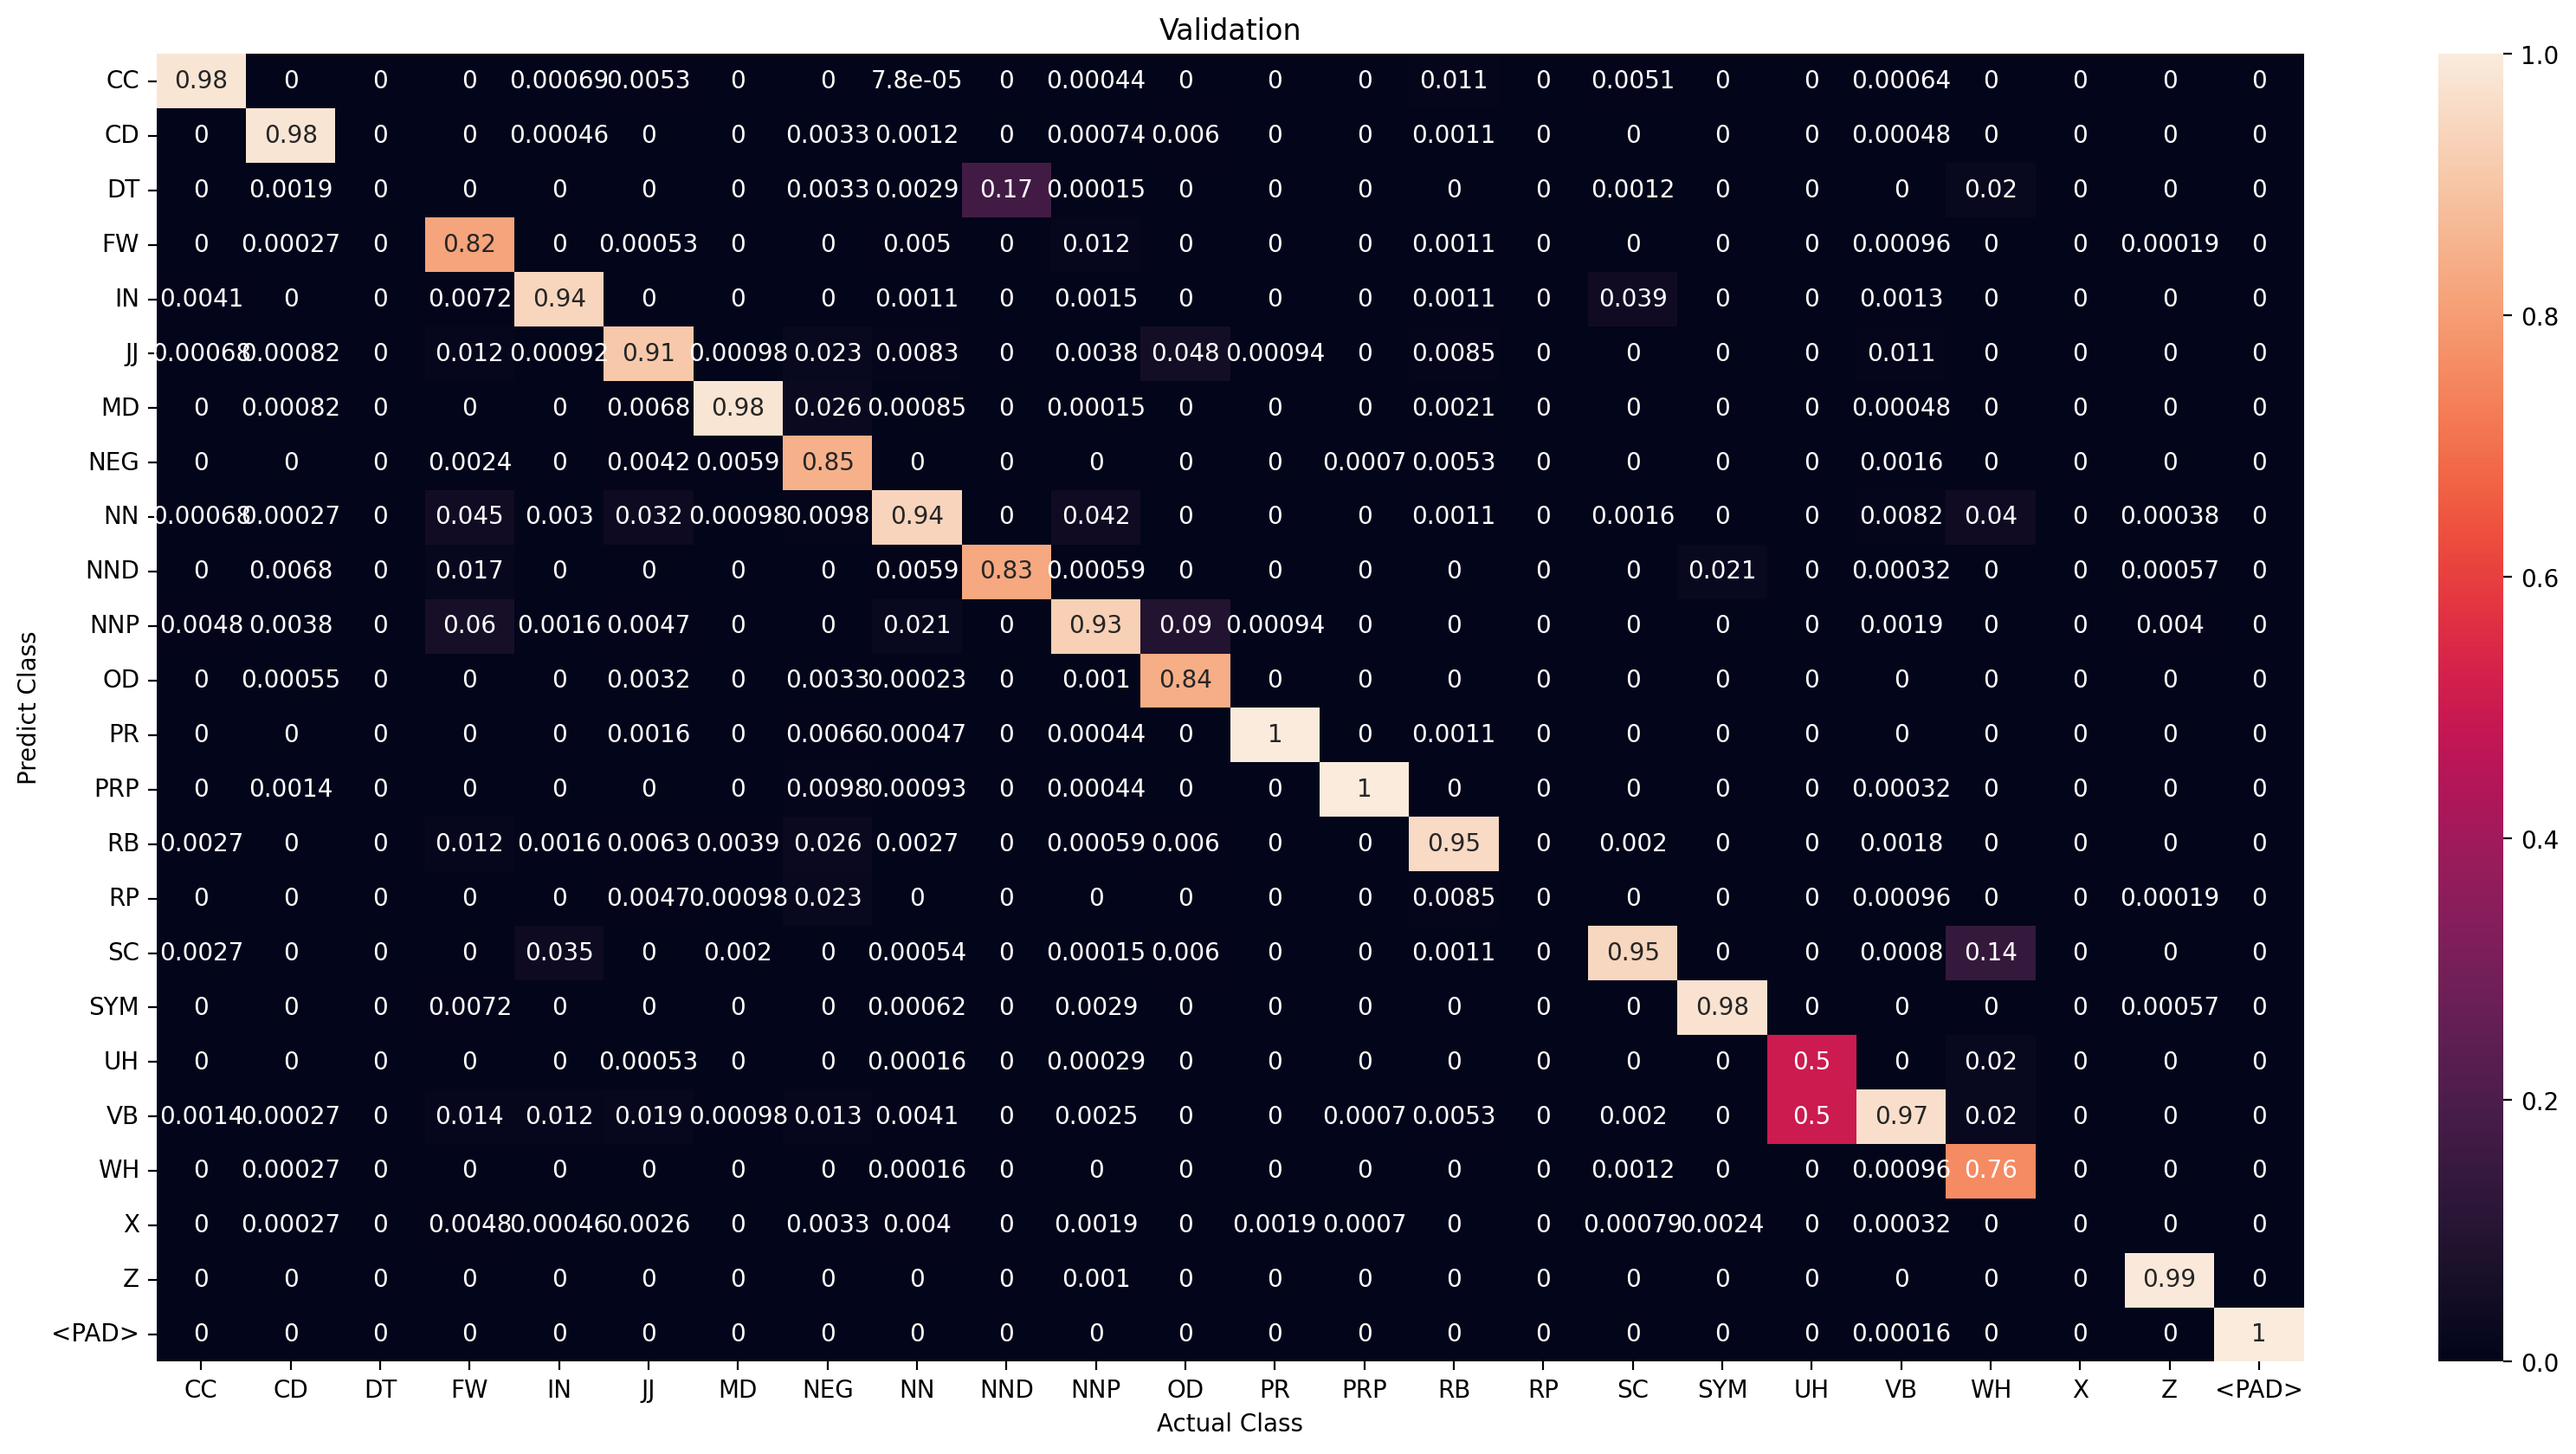

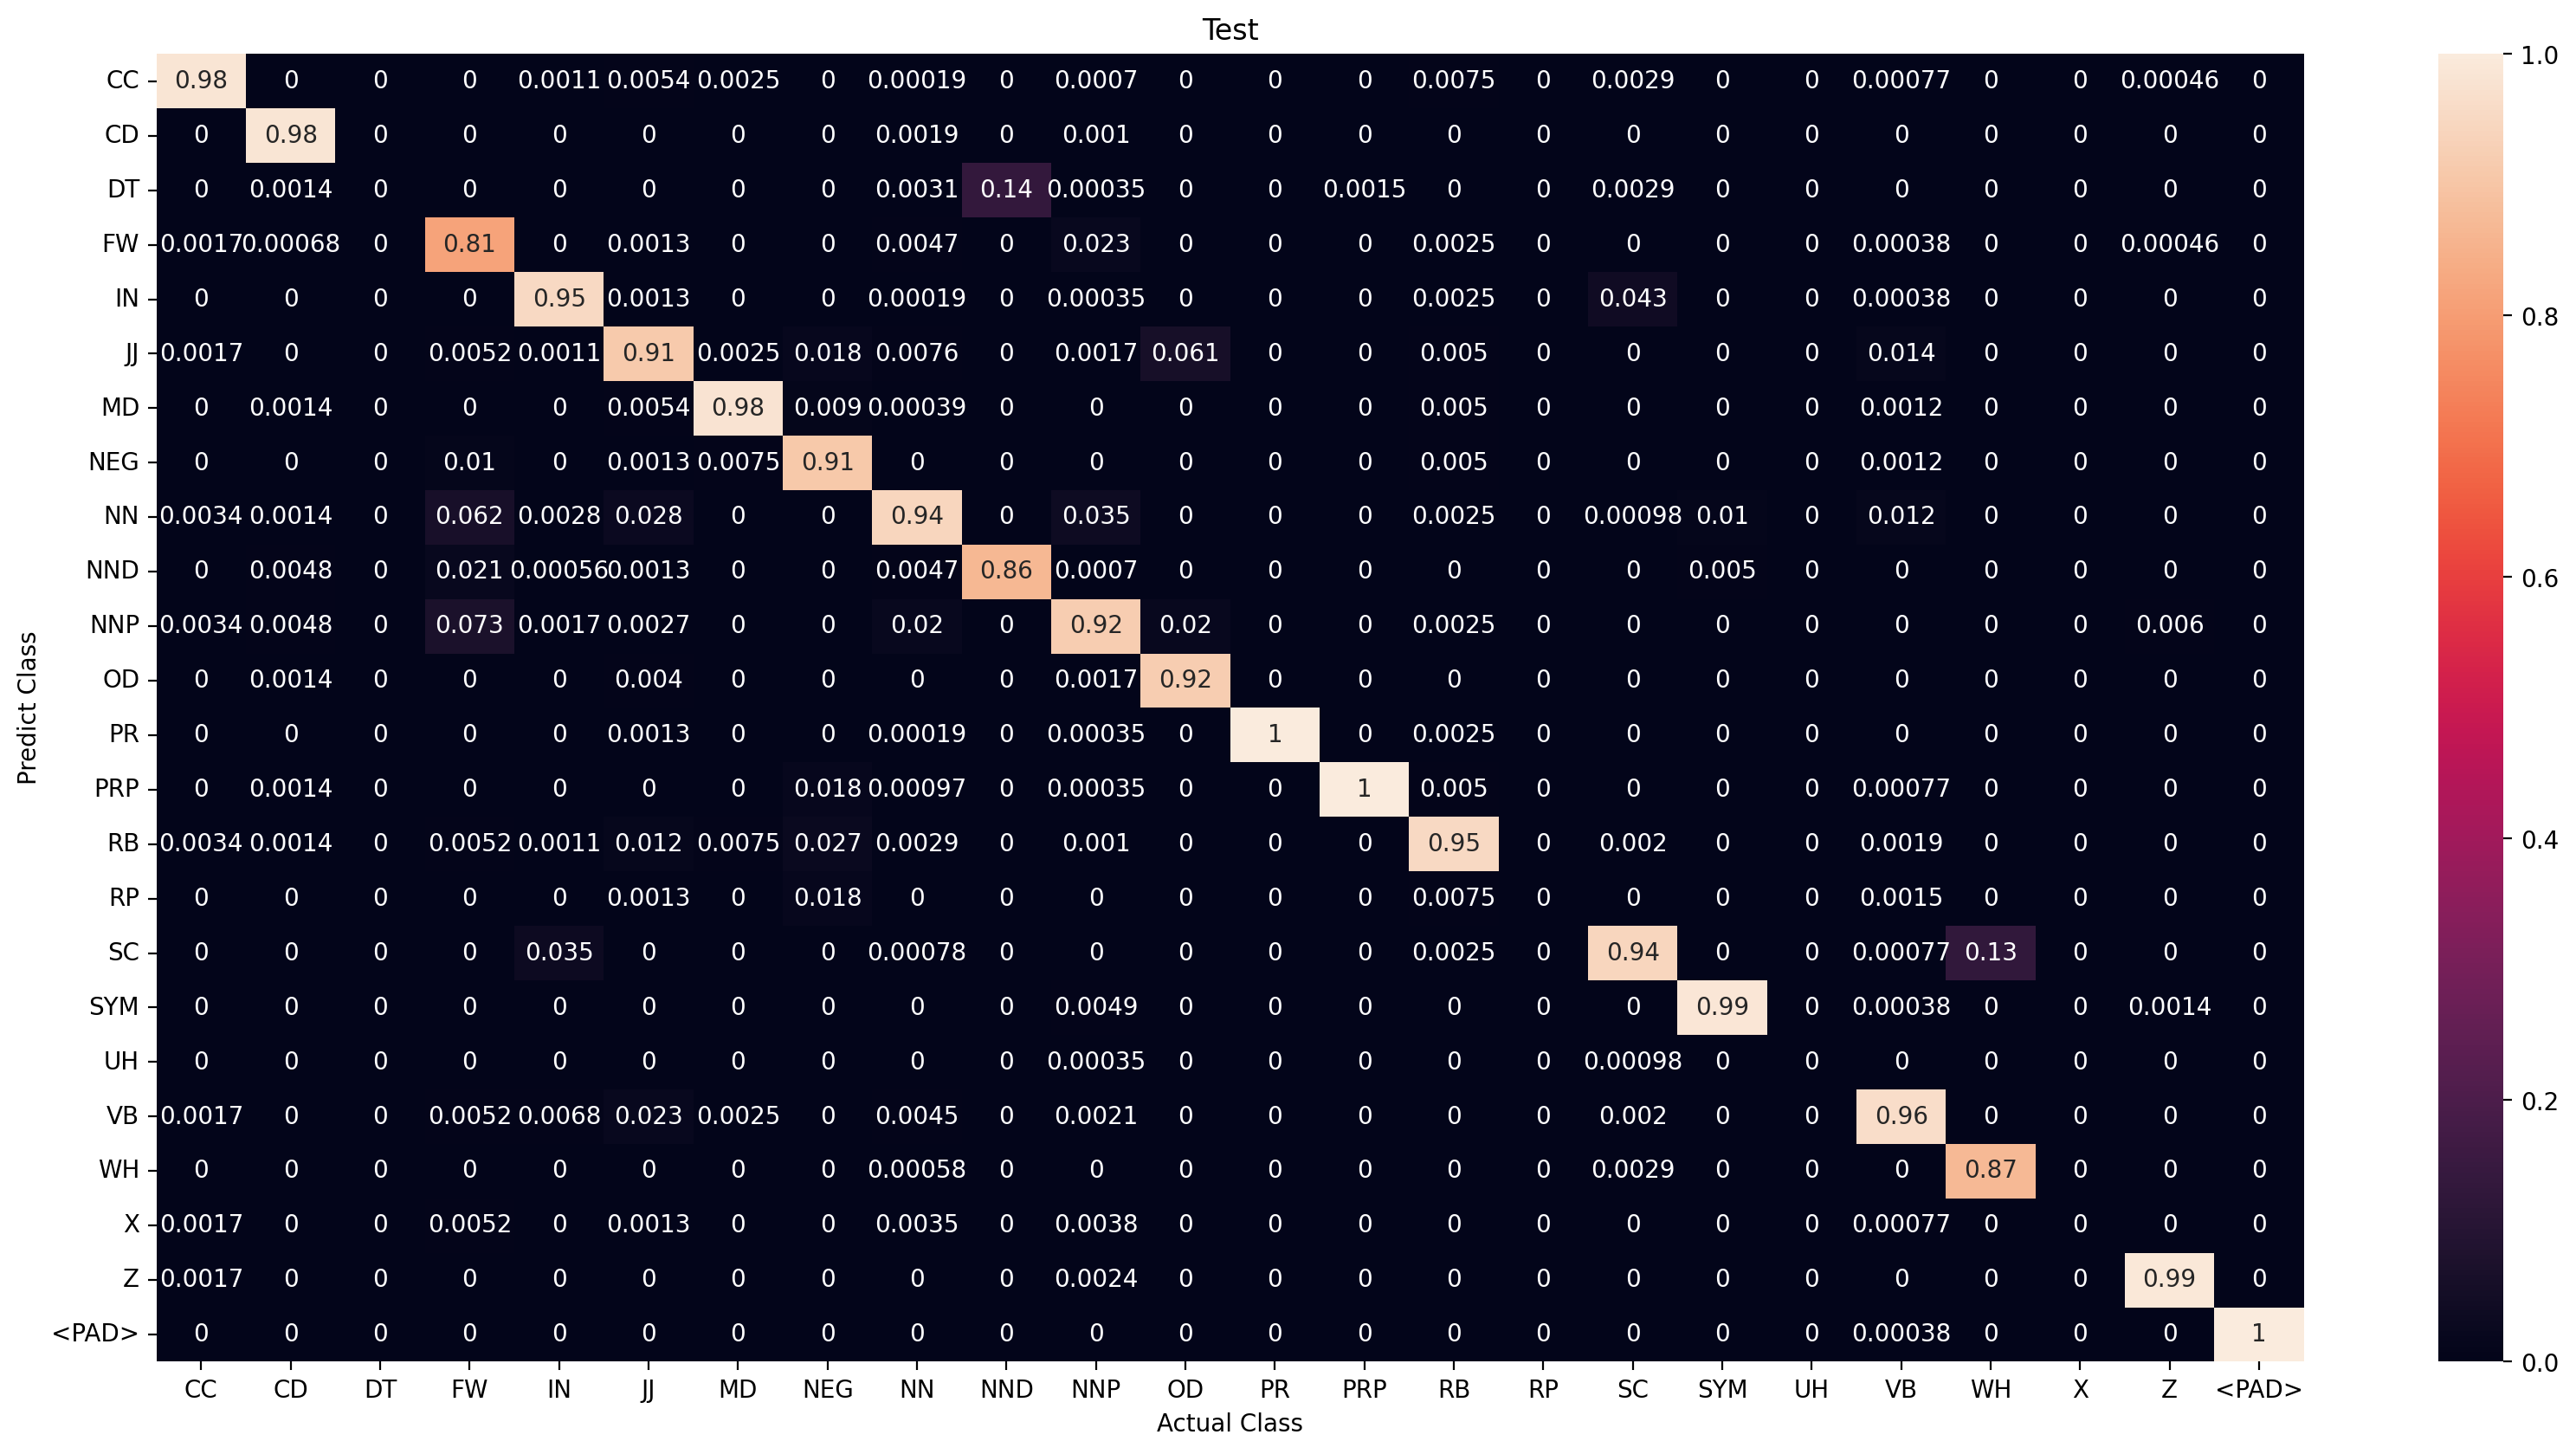

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5211       | CC    : 135      |
| CD    : 12730  | CD    : 12652      | CD    : 78       |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1364       | FW    : 250      |
| IN    : 15342  | IN    : 15225      | IN    : 117      |
| JJ    : 6981   | JJ    : 6587       | JJ    : 394      |
| MD    : 3799   | MD    : 3669       | MD    : 130      |
| NEG   : 1118   | NEG   : 1005       | NEG   : 113      |
| NN    : 44369  | NN    : 43892      | NN    : 477      |
| NND   : 1047   | NND   : 545        | NND   : 502      |
| NNP   : 25175  | NNP   : 24785      | NNP   : 390      |
| OD    : 524    | OD    : 505        | OD    : 19       |
| PR    : 3880   | PR    : 3857       | PR    : 23       |
| PRP   : 5471   | PRP   : 5390       | PRP   : 81       |
| RB    : 3477   | RB    : 3247       | RB    : 230      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8, 19, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11041
Wrong prediction            : 765
Percentage correct oov pred : 93.52024394375741

Validation
Number OOV token            : 3366
Correct prediction          : 2969
Wrong prediction            : 397
Percentage correct oov pred : 88.2055852644088

Test
Number OOV token            : 1390
Correct prediction          : 1243
Wrong prediction            : 147
Percentage correct oov pred : 89.42446043165468



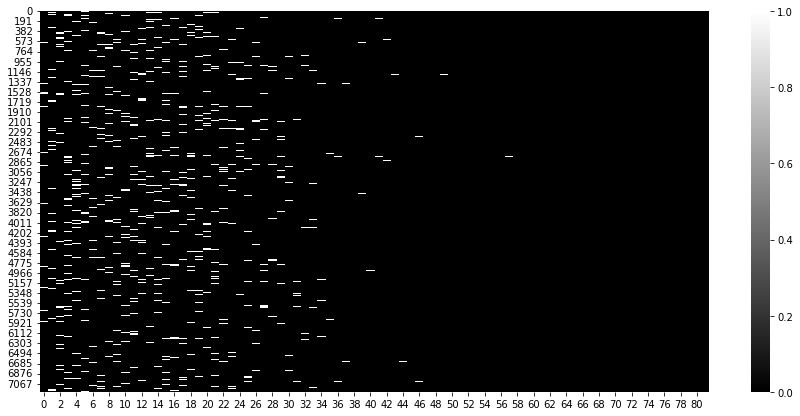

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

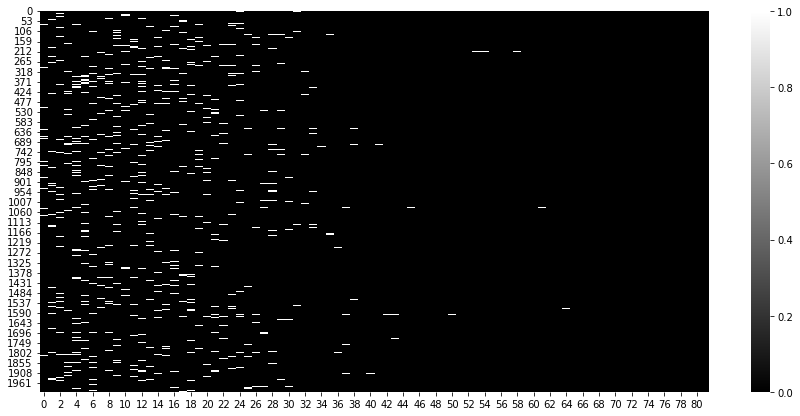

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

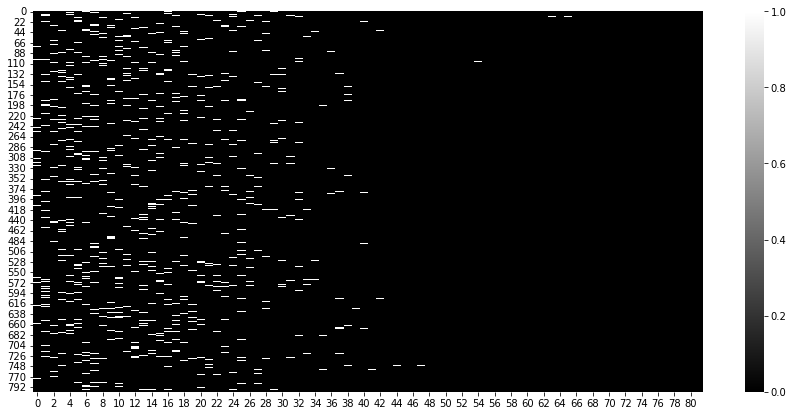

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);